## What is the causal effect of extreme heat on electricity demand in California?

Data Setup: For this question we're combining daily energy data and daily temperature data in California from the years 2016-2023. Weather data was obtained from NOAA, and energy data was taken from the US Energy Information Administration. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
from graphviz import Digraph

### Generate Causal Diagram

In [4]:
# Generates the causal diagram - this image can be found within the final report. 

dot = Digraph()
dot.node('A', 'Extreme Heat')
dot.node('B', 'Electricity Demand')
dot.node('C', 'Weekday')
dot.node('D', 'Month')
dot.node('E', 'Year')
dot.node('F', 'Weather (Rain, Snow, Wind)')
dot.node('G', 'C02 Generation')

dot.edges(['AB', 'CA', 'CB', 'DA', 'DB', 'EA', 'EB', 'FA', 'FB', 'AG', 'BG'])
dot.render('Extreme_Heat_Diagram', format='png', cleanup=True)

'Extreme_Heat_Diagram.png'

### Data Cleaning

In [6]:
# This function is utilized to perform some cleaning on the data - this is taken directly from the EDA section

def eda(data):
    df = data.copy()
    df = df[['Region', 'UTC time', 'Local date', 'Hour', 'Local time', 'Time zone',
                         'DF', 'D', 'Sum (NG)', 'NG: COL', 'NG: NG', 'NG: NUC',
                         'NG: OIL', 'NG: WAT', 'NG: SUN', 'NG: WND', 'NG: OTH', 'CO2 Emissions Generated']]
    df['Local date'] = pd.to_datetime(df['Local date'], format='%d%b%Y')
    df['day'] = df['Local date'].dt.day
    df['month'] = df['Local date'].dt.month
    df['year'] = df['Local date'].dt.year
    df['dotw'] = df['Local date'].dt.dayofweek
    df = df[(df['year'] >= 2016) & (df['year'] <= 2023)]
    df['Hour'] = df['Hour'] - 1
    df['D'] = pd.to_numeric(df['D'].str.replace(',', '', regex=False), errors='coerce')
    df['D'] = df['D'] / 1000
    return df

In [7]:
# Read California dataset and perform basic cleaning

california = eda(pd.read_csv('california.csv', low_memory=False))

In [8]:
# Ensure columns are in numeric form

california['NG: SUN'] = pd.to_numeric(california['NG: SUN'], errors='coerce')
california['NG: WND'] = pd.to_numeric(california['NG: WND'], errors='coerce')

In [9]:
# Group the dataset by date, summing demand and relevant NG columns

cal_bydate = california.groupby('Local date')[['D', 'NG: SUN', 'NG: WND']].sum().reset_index()

In [10]:
# Clean date related columns

cal_bydate['Local date'] = pd.to_datetime(cal_bydate['Local date'], format='%d%b%Y')
cal_bydate['day'] = cal_bydate['Local date'].dt.day
cal_bydate['month'] = cal_bydate['Local date'].dt.month
cal_bydate['year'] = cal_bydate['Local date'].dt.year
cal_bydate['dotw'] = cal_bydate['Local date'].dt.dayofweek

In [11]:
cal_bydate

,Local date,D,NG: SUN,NG: WND,day,month,year,dotw
0,2016-01-01,689.307,0.0,0.0,1,1,2016,4
1,2016-01-02,690.124,0.0,0.0,2,1,2016,5
2,2016-01-03,674.717,0.0,0.0,3,1,2016,6
3,2016-01-04,732.453,0.0,0.0,4,1,2016,0
4,2016-01-05,757.620,0.0,0.0,5,1,2016,1
...,...,...,...,...,...,...,...,...
2917,2023-12-27,699.599,-194.0,7360.0,27,12,2023,2
2918,2023-12-28,690.170,372.0,5189.0,28,12,2023,3
2919,2023-12-29,679.225,11.0,11161.0,29,12,2023,4
2920,2023-12-30,659.481,502.0,4064.0,30,12,2023,5


Here we combine the energy & weather columns. Snowfall, percipitation, wind and max temperature data across all recorded stations in California are averaged, making the data granularity daily & statewide.

In [13]:
# A collection of weather data in California from 2016-2023 record by NOAA

weather_master = pd.read_csv('weather_master.csv')

In [14]:
# Fill NaN values with 0s

weather_master['PRCP'] = weather_master['PRCP'].fillna(0)
weather_master['SNOW'] = weather_master['SNOW'].fillna(0)
weather_master['AWND'] = weather_master['AWND'].fillna(0)

In [15]:
# Drop average and min columns and group by date - we only utilize temperature max

max_master = weather_master.drop(columns=['TAVG', 'TMIN'])
max_master = max_master.dropna(subset=['TMAX'])
max_master = max_master.groupby('DATE').mean().reset_index()

In [16]:
max_master

,DATE,AWND,PRCP,SNOW,TMAX
0,2016-01-01,0.673798,0.000353,0.003193,46.576471
1,2016-01-02,0.551973,0.002488,0.001658,48.920398
2,2016-01-03,0.633372,0.006017,0.000000,51.752066
3,2016-01-04,0.678843,0.056992,0.004132,51.669421
4,2016-01-05,1.080867,0.404288,0.027823,48.569558
...,...,...,...,...,...
2794,2023-12-27,0.733477,0.056360,0.000000,57.156757
2795,2023-12-28,0.542432,0.048486,0.005405,59.099099
2796,2023-12-29,0.774195,0.093978,0.001808,59.365280
2797,2023-12-30,0.717208,0.172956,0.011861,53.313869


In [17]:
# Ensure the Local date in energy data is in date format (strip time if necessary)
cal_bydate['Local date'] = pd.to_datetime(cal_bydate['Local date']).dt.date

# Ensure the DATE in temperature data is in date format
max_master['DATE'] = pd.to_datetime(max_master['DATE']).dt.date

# Combine data into one table
combined_data = pd.merge(
    cal_bydate,
    max_master,
    left_on="Local date",
    right_on="DATE",
    how="inner"
)

# Drop the duplicate 'DATE' column
combined_data.drop(columns=["DATE"], inplace=True)

In [18]:
combined_data

,Local date,D,NG: SUN,NG: WND,day,month,year,dotw,AWND,PRCP,SNOW,TMAX
0,2016-01-01,689.307,0.0,0.0,1,1,2016,4,0.673798,0.000353,0.003193,46.576471
1,2016-01-02,690.124,0.0,0.0,2,1,2016,5,0.551973,0.002488,0.001658,48.920398
2,2016-01-03,674.717,0.0,0.0,3,1,2016,6,0.633372,0.006017,0.000000,51.752066
3,2016-01-04,732.453,0.0,0.0,4,1,2016,0,0.678843,0.056992,0.004132,51.669421
4,2016-01-05,757.620,0.0,0.0,5,1,2016,1,1.080867,0.404288,0.027823,48.569558
...,...,...,...,...,...,...,...,...,...,...,...,...
2794,2023-12-27,699.599,-194.0,7360.0,27,12,2023,2,0.733477,0.056360,0.000000,57.156757
2795,2023-12-28,690.170,372.0,5189.0,28,12,2023,3,0.542432,0.048486,0.005405,59.099099
2796,2023-12-29,679.225,11.0,11161.0,29,12,2023,4,0.774195,0.093978,0.001808,59.365280
2797,2023-12-30,659.481,502.0,4064.0,30,12,2023,5,0.717208,0.172956,0.011861,53.313869


Here we define significant weather events - specifically rain, snow, and wind events - to allow for the matching of those events. All three are defined "significant" if they are in the 90th or higher quantile. 

In [20]:
combined_data.columns

Index(['Local date', 'D', 'NG: SUN', 'NG: WND', 'day', 'month', 'year', 'dotw',
       'AWND', 'PRCP', 'SNOW', 'TMAX'],
      dtype='object')

In [21]:
# Calculate quantiles and filter

prcp_threshold = combined_data['PRCP'].quantile(0.90)
snow_threshold = combined_data['SNOW'].quantile(0.90)
wind_threshold = combined_data['AWND'].quantile(0.90)


combined_data['Significant_Rain'] = (combined_data['PRCP'] > prcp_threshold).astype(int)
combined_data['Significant_Snow'] = (combined_data['SNOW'] > snow_threshold).astype(int)
combined_data['Significant_Wind'] = (combined_data['AWND'] > snow_threshold).astype(int)

Here we define a new column, "Extreme" that indicates whether that day's weather is extreme. From the OEHHA: "An extreme heat event occurs between April and October when the temperature is at or above a location-specific historical temperature threshold, set at the 95th percentile of daily maximum for daytime extreme events" We will follow that definition for this data. 

In [23]:
percentiles = combined_data.groupby('month')['TMAX'].quantile(0.95).reset_index()
percentiles.columns = ['month', 'TMAX_95th']

combined_data = combined_data.merge(percentiles, on='month', how='left')

combined_data['Extreme'] = combined_data['TMAX'] >= combined_data['TMAX_95th']

### EDA

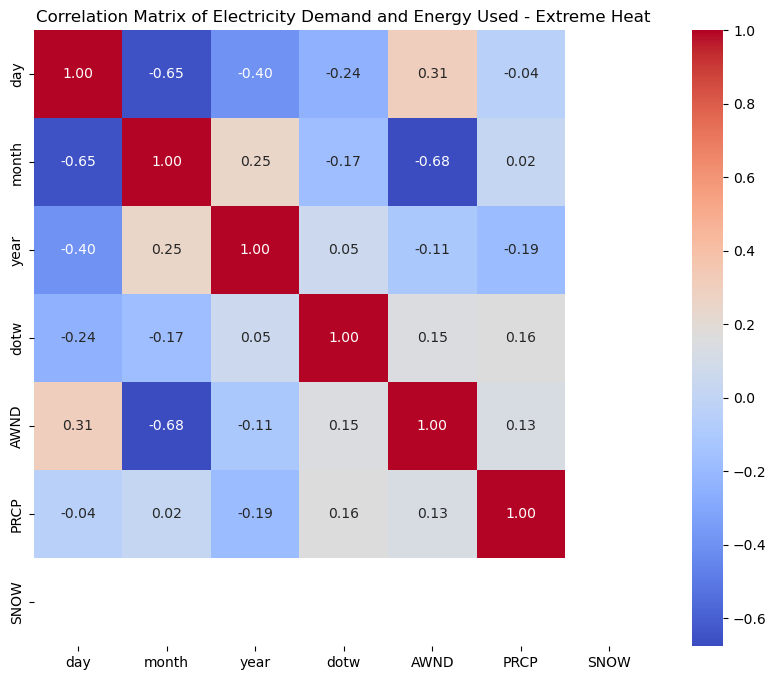

In [155]:
# Compare confounding variable correlation matrices between extreme heat days and non-extreme heat days.

correlation_columns = ['day', 'month', 'year', 'dotw', 'AWND', 'PRCP', 'SNOW']

extreme_days = combined_data[combined_data["Extreme"] == True]
normal_days = combined_data[combined_data["Extreme"] == False]

# Create correlation matrix and plot 
corr_matrix = extreme_days[['day', 'month', 'year', 'dotw', 'AWND', 'PRCP', 'SNOW']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Electricity Demand and Energy Used - Extreme Heat')
plt.savefig("Correlation of Electricity Demand and Energy Used.png")
plt.show()

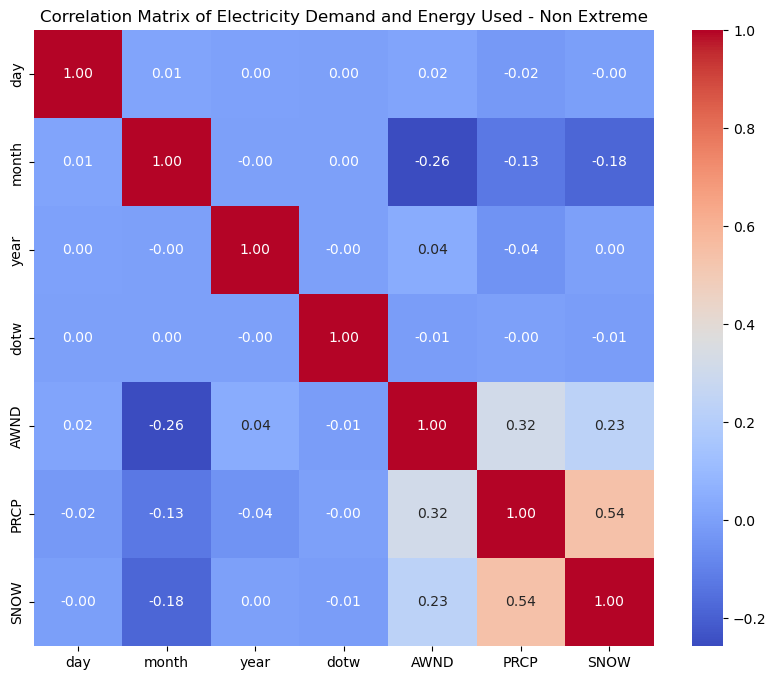

In [153]:
corr_matrix = normal_days[['day', 'month', 'year', 'dotw', 'AWND', 'PRCP', 'SNOW']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Electricity Demand and Energy Used - Non Extreme')
plt.savefig("Correlation of Electricity Demand and Energy Used.png")
plt.show()

## Matching

We will utilize matching, joining extreme weather days to non-extreme weather days that share the same day of the week, month, and significant weather attributes. After matching these events we will take the averaged difference between the energy demand of the treated days (days with extreme heat) and untreated days. 

In [27]:
treated = combined_data[combined_data['Extreme'] == 1]
untreated = combined_data[combined_data['Extreme'] == 0]

In [28]:
# Covariates to use for matching
matching_covariates = ['dotw', 'month', 'Significant_Rain', 'Significant_Snow', 'Significant_Wind']

# Merge treated and untreated on matching columns
matched_pairs = pd.merge(
    treated,
    untreated,
    on=matching_covariates,
    suffixes=('_treated', '_untreated')
)

In [30]:
matched_pairs

,Local date_treated,D_treated,NG: SUN_treated,NG: WND_treated,day_treated,month,year_treated,dotw,AWND_treated,PRCP_treated,...,NG: SUN_untreated,NG: WND_untreated,day_untreated,year_untreated,AWND_untreated,PRCP_untreated,SNOW_untreated,TMAX_untreated,TMAX_95th_untreated,Extreme_untreated
0,2016-02-09,719.317,0.0,0.0,9,2,2016,1,0.609738,0.000000,...,0.0,0.0,23,2016,0.678993,0.001191,0.000000,67.114094,71.322869,False
1,2016-02-09,719.317,0.0,0.0,9,2,2016,1,0.609738,0.000000,...,0.0,0.0,14,2017,0.509543,0.007310,0.010152,64.018613,71.322869,False
2,2016-02-09,719.317,0.0,0.0,9,2,2016,1,0.609738,0.000000,...,0.0,0.0,6,2018,0.718194,0.000117,0.000000,68.043478,71.322869,False
3,2016-02-09,719.317,0.0,0.0,9,2,2016,1,0.609738,0.000000,...,0.0,0.0,13,2018,0.698569,0.006246,0.019192,55.134680,71.322869,False
4,2016-02-09,719.317,0.0,0.0,9,2,2016,1,0.609738,0.000000,...,0.0,0.0,20,2018,0.667339,0.003881,0.019492,45.961017,71.322869,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,2023-12-16,678.531,-84.0,11224.0,16,12,2023,5,0.526606,0.000219,...,-348.0,7599.0,17,2022,0.509962,0.000095,0.000000,52.041588,64.681460,False
3792,2023-12-16,678.531,-84.0,11224.0,16,12,2023,5,0.526606,0.000219,...,991.0,9251.0,24,2022,0.509924,0.004106,0.000000,61.159696,64.681460,False
3793,2023-12-16,678.531,-84.0,11224.0,16,12,2023,5,0.526606,0.000219,...,336.0,879.0,2,2023,0.723509,0.045636,0.000909,55.012727,64.681460,False
3794,2023-12-16,678.531,-84.0,11224.0,16,12,2023,5,0.526606,0.000219,...,467.0,3515.0,9,2023,0.824991,0.004102,0.003630,56.034483,64.681460,False


In [31]:
att = (matched_pairs['D_treated'] - matched_pairs['D_untreated']).mean()
att

95.80809430979977

This outcome indicates that days exhibiting "extreme" heat (temperatures in the upper 5%) cause a roughly 95.8 gigawatt increase in demand. Though, this value can change as we change our definitions of what "extreme" heat and "significant weather" is considered. Lowering the threshold of what is considered extreme heat will likely decrease this outcome. Let's consider what this change might look like to get a sense of the causation of various maximum temperatures on energy demand.

In [34]:
# Create range of quantiles

import numpy as np

quantiles = np.linspace(0.50, 0.99, 50)

In [35]:
# This code runs over a range of quantiles, re-calculating the ATT based on different quantile thresholds for maximum temperature 

att_results = []
matching_results = []


for q in quantiles:
    tmax_threshold = combined_data['TMAX'].quantile(q)
    
    combined_data['Extreme'] = (combined_data['TMAX'] > tmax_threshold).astype(int)
    
    treated = combined_data[combined_data['Extreme'] == 1]
    untreated = combined_data[combined_data['Extreme'] == 0]
    
    matched_pairs = pd.merge(
        treated,
        untreated,
        on=matching_covariates,
        suffixes=('_treated', '_untreated')
    )

    att = (matched_pairs['D_treated'] - matched_pairs['D_untreated']).mean()
    
    matching_results.append(len(matched_pairs))
    
    att_results.append(att)

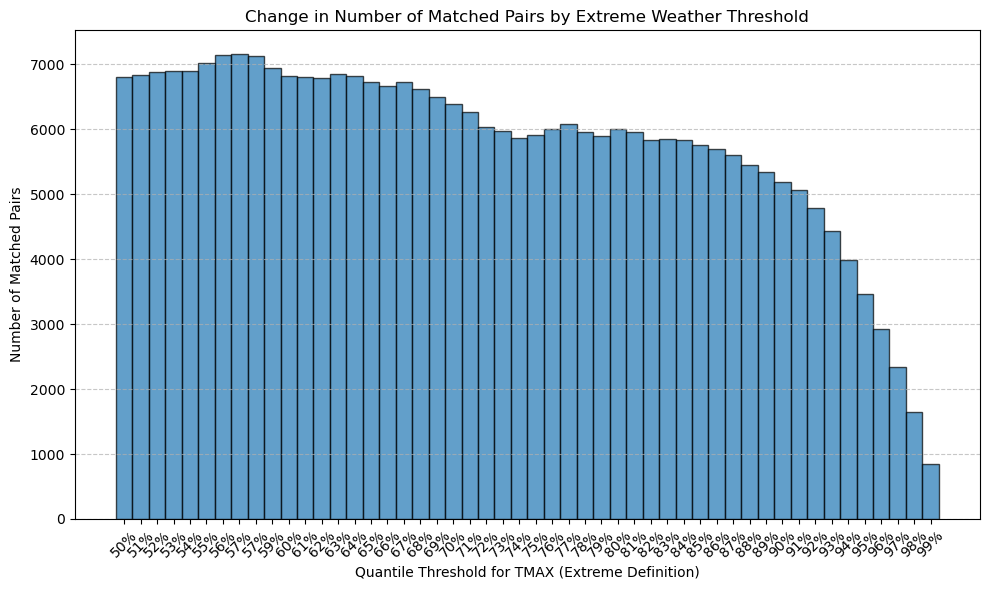

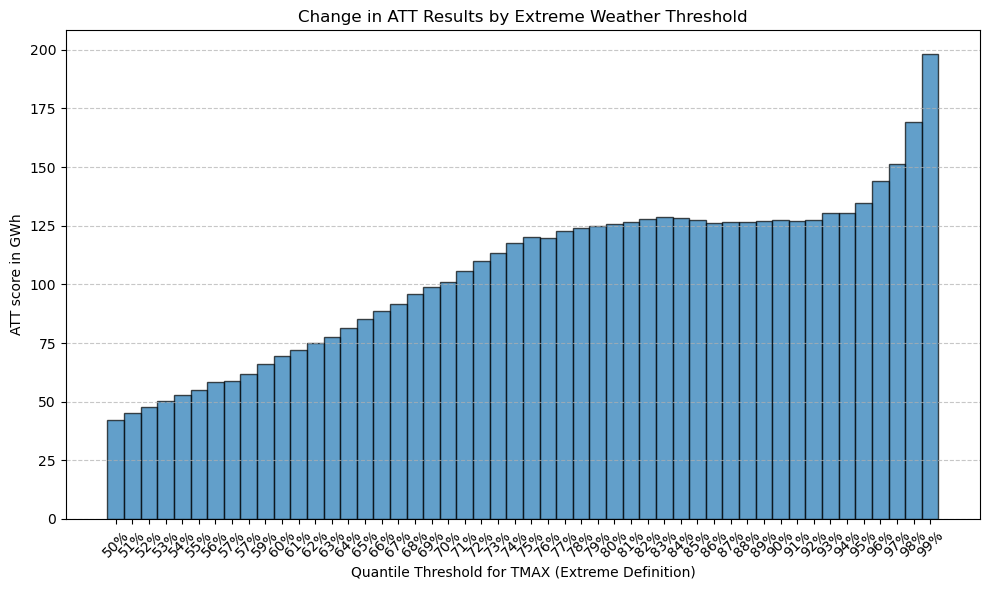

In [36]:
# Matched Pairs
plt.figure(figsize=(10, 6))
plt.bar(quantiles, matching_results, width=0.01, edgecolor='black', alpha=0.7, label='Matched Pairs')
plt.xlabel('Quantile Threshold for TMAX (Extreme Definition)')
plt.ylabel('Number of Matched Pairs')
plt.title('Change in Number of Matched Pairs by Extreme Weather Threshold')
plt.xticks(quantiles, labels=[f"{int(q * 100)}%" for q in quantiles], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout()
plt.savefig("Matched_Chart_with_Grid.png")
plt.show()

# ATT Results
plt.figure(figsize=(10, 6))
plt.bar(quantiles, att_results, width=0.01, edgecolor='black', alpha=0.7, label='ATT Results')
plt.xlabel('Quantile Threshold for TMAX (Extreme Definition)')
plt.ylabel('ATT score in GWh')
plt.title('Change in ATT Results by Extreme Weather Threshold')
plt.xticks(quantiles, labels=[f"{int(q * 100)}%" for q in quantiles], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("ATT_Chart_with_Grid.png")
plt.show()


Of note: The ATT value appears to steadily increase as the quantile threshold increases, before flatenning from around 80% to 94%, and then exponentially increases from 95% to 99%. Observing this is relevant as it shows that infrastructure to account for the demand of these 5% events are incredibly important, and also shows that there is little change in demand between the 77% and 93% quantiles. 

In [40]:
# Create ATT dictionary

quantile_to_att = dict(zip(quantiles, att_results))

What is shown below is that despite having a 5 degree separation, less than the 77-93% quantile's of 7 degrees, the difference between the demand is significantly higher between the 99% and 93% quantile. In fact, the expected difference in demand caused by 95.7 degree max temperatures and 90.6 degrees is over 9 times higher than the same difference between 90.6 and 83.5 degree temperatures.

In [42]:
# Calculate quantile differences and display respective temperatures.

lower = combined_data['TMAX'].quantile(.8)
upper = combined_data['TMAX'].quantile(.93)

att_difference = quantile_to_att[.9299999999999999] - quantile_to_att[.77]

print("77% Quantile: ", lower, "degrees")
print("93% Quantile: ", upper, "degrees")
print("ATT difference: ", att_difference)

77% Quantile:  85.21995336883661 degrees
93% Quantile:  90.6246949980801 degrees
ATT difference:  7.531674789268678


In [44]:
# Calculate quantile differences and display respective temperatures.

lower = combined_data['TMAX'].quantile(.93)
upper = combined_data['TMAX'].quantile(.99)

att_difference = quantile_to_att[.99] - quantile_to_att[.9299999999999999]

print("93% Quantile: ", lower, "degrees")
print("99% Quantile: ", upper, "degrees")
print("ATT difference: ", att_difference)

93% Quantile:  90.6246949980801 degrees
99% Quantile:  95.73183437842142 degrees
ATT difference:  68.1296714916337


## Inverse Propensity Weighting

Below was our attempt at utilizing IPW to estimate the causal effect, though the rarity of the events made this a problematic method. Other parameters were tried along with transformations of those parameters, though the resulting propensity scores either remained too low or too close to 1. 

In [120]:
X = combined_data[['dotw', 'month', 'year', 'Significant_Rain', 'Significant_Snow', 'Significant_Wind']]
y = combined_data['Extreme']

In [134]:
# Fit logistic regression model

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()


model = LogisticRegression(max_iter=1000)
model.fit(X, y)

LogisticRegression(max_iter=1000)

In [136]:
# Obtain propensity scores

propensity_scores = model.predict_proba(X)[:, 1]
propensity_df = pd.DataFrame(propensity_scores, columns=['Propensity Score'])
propensity_df

,Propensity Score
0,0.005629
1,0.006688
2,0.007945
3,0.002820
4,0.001401
...,...
2794,0.015515
2795,0.018401
2796,0.021810
2797,0.010940


In [138]:
# As you can see, propensity scores come out much too small

propensity_df.describe()

,Propensity Score
count,2799.000000
mean,0.010004
std,0.006251
min,0.000533
25%,0.005439
50%,0.008753
75%,0.013263
max,0.031204


In [140]:
combined_data['pscore'] = propensity_scores

In [144]:
# Calculate the trimmed IPW estimate (currently commented out due to division by zero error from small scores)

"""
narrowed_prop = combined_data[(combined_data['pscore'] > 0.1) & (combined_data['pscore'] < 0.9)]
n = len(narrowed_prop)
treated_rows_cleaned = narrowed_prop.loc[narrowed_prop['Extreme'] == 1].copy()
untreated_rows_cleaned = narrowed_prop.loc[narrowed_prop['Extreme'] == 0].copy()
treated_rows_cleaned['Weighted Demand'] = treated_rows_cleaned['D'] * (1 / treated_rows_cleaned['pscore'])
untreated_rows_cleaned['Weighted Demand'] = untreated_rows_cleaned['D'] * (1 / (1 - untreated_rows_cleaned['pscore']))
trimmed_ipw_estimate = ((1 / n) * treated_rows_cleaned['Weighted Demand'].sum()) - ((1 / n) * untreated_rows_cleaned['Weighted Demand'].sum())
trimmed_ipw_estimate
"""

"\nnarrowed_prop = combined_data[(combined_data['pscore'] > 0.1) & (combined_data['pscore'] < 0.9)]\nn = len(narrowed_prop)\ntreated_rows_cleaned = narrowed_prop.loc[narrowed_prop['Extreme'] == 1].copy()\nuntreated_rows_cleaned = narrowed_prop.loc[narrowed_prop['Extreme'] == 0].copy()\ntreated_rows_cleaned['Weighted Demand'] = treated_rows_cleaned['D'] * (1 / treated_rows_cleaned['pscore'])\nuntreated_rows_cleaned['Weighted Demand'] = untreated_rows_cleaned['D'] * (1 / (1 - untreated_rows_cleaned['pscore']))\ntrimmed_ipw_estimate = ((1 / n) * treated_rows_cleaned['Weighted Demand'].sum()) - ((1 / n) * untreated_rows_cleaned['Weighted Demand'].sum())\ntrimmed_ipw_estimate\n"